## 1.导入依赖包

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras import Model

## 2.导入数据集

In [2]:
train = pd.read_csv('../../data/fashion_train.csv')
test = pd.read_csv('../../data/fashion_test.csv')
print(train.shape, test.shape)

(42000, 785) (28000, 784)


## 3.数据预处理

In [3]:
input_shape = (28, 28, 1)
x = np.array(train.iloc[:, 1:])
y = keras.utils.to_categorical(np.array(train.iloc[:, 0]))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
print(x_train.shape, y_train.shape)

x_test = np.array(test.iloc[:, 0:])
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
print(x_train.shape, y_train.shape)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255

batch_size = 64
classes = 10
epochs = 5

(33600, 784) (33600, 10)
(33600, 28, 28, 1) (33600, 10)


## 4.建立模型

In [4]:
class ConvBNRelu(Model):
    def __init__(self, ch, kernelsz=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(ch, kernelsz, strides=strides, padding=padding),
            BatchNormalization(),
            Activation('relu')
        ])

    def call(self, x):
        x = self.model(x,
                       training=False)
        return x


class InceptionBlk(Model):
    def __init__(self, ch, strides=1):
        super(InceptionBlk, self).__init__()
        self.ch = ch
        self.strides = strides
        self.c1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_2 = ConvBNRelu(ch, kernelsz=3, strides=1)
        self.c3_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c3_2 = ConvBNRelu(ch, kernelsz=5, strides=1)
        self.p4_1 = MaxPool2D(3, strides=1, padding='same')
        self.c4_2 = ConvBNRelu(ch, kernelsz=1, strides=strides)

    def call(self, x):
        x1 = self.c1(x)
        x2_1 = self.c2_1(x)
        x2_2 = self.c2_2(x2_1)
        x3_1 = self.c3_1(x)
        x3_2 = self.c3_2(x3_1)
        x4_1 = self.p4_1(x)
        x4_2 = self.c4_2(x4_1)
        x = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return x


num_blocks = 2
num_classes = 10
in_channels = 16
out_channels = 16
blocks = tf.keras.models.Sequential()
for block_id in range(num_blocks):
    for layer_id in range(2):
        if layer_id == 0:
            block = InceptionBlk(out_channels, strides=2)
        else:
            block = InceptionBlk(out_channels, strides=1)
        blocks.add(block)
    out_channels *= 2

model = keras.models.Sequential([
    ConvBNRelu(16),
    blocks,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

## 5.定义优化器、损失函数和评价指标

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 6.断点续训

In [6]:
save_path = './checkpoint/inception.ckpt'
if os.path.exists(save_path + '.index'):
    print('model loading')
    model.load_weights(save_path)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=save_path,
                                              save_weights_only=True,
                                              save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

## 7.训练模型

In [7]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[cp_callback, callback])

Epoch 1/5
525/525 [==============================] - 48s 91ms/step - loss: 0.8532 - accuracy: 0.6699 - val_loss: 0.5928 - val_accuracy: 0.7810
Epoch 2/5
525/525 [==============================] - 47s 90ms/step - loss: 0.5153 - accuracy: 0.8073 - val_loss: 0.4370 - val_accuracy: 0.8376
Epoch 3/5
525/525 [==============================] - 49s 93ms/step - loss: 0.4165 - accuracy: 0.8454 - val_loss: 0.4100 - val_accuracy: 0.8556
Epoch 4/5
525/525 [==============================] - 48s 91ms/step - loss: 0.3593 - accuracy: 0.8680 - val_loss: 0.3969 - val_accuracy: 0.8589
Epoch 5/5
525/525 [==============================] - 48s 92ms/step - loss: 0.3210 - accuracy: 0.8816 - val_loss: 0.3561 - val_accuracy: 0.8723


## 8.预测结果

In [8]:
result = model.predict(x_test)
pred = tf.argmax(result, axis=1)
df = pd.DataFrame(pred, columns=['label'])
df.to_csv(path_or_buf='Submission.csv', index_label='image_id')

## 9.损失和准确率可视化

In [9]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


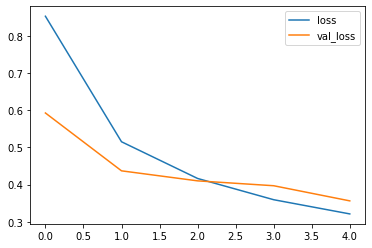

In [10]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()
plt.show()

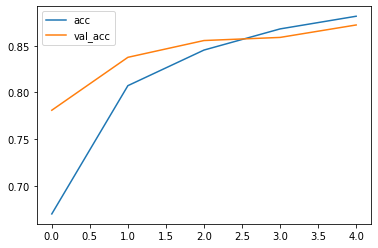

In [11]:
plt.plot(history.epoch, history.history.get('accuracy'), label='acc')
plt.plot(history.epoch, history.history.get('val_accuracy'), label='val_acc')
plt.legend()
plt.show()